In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_2nd
cluster = cluster_2nd

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

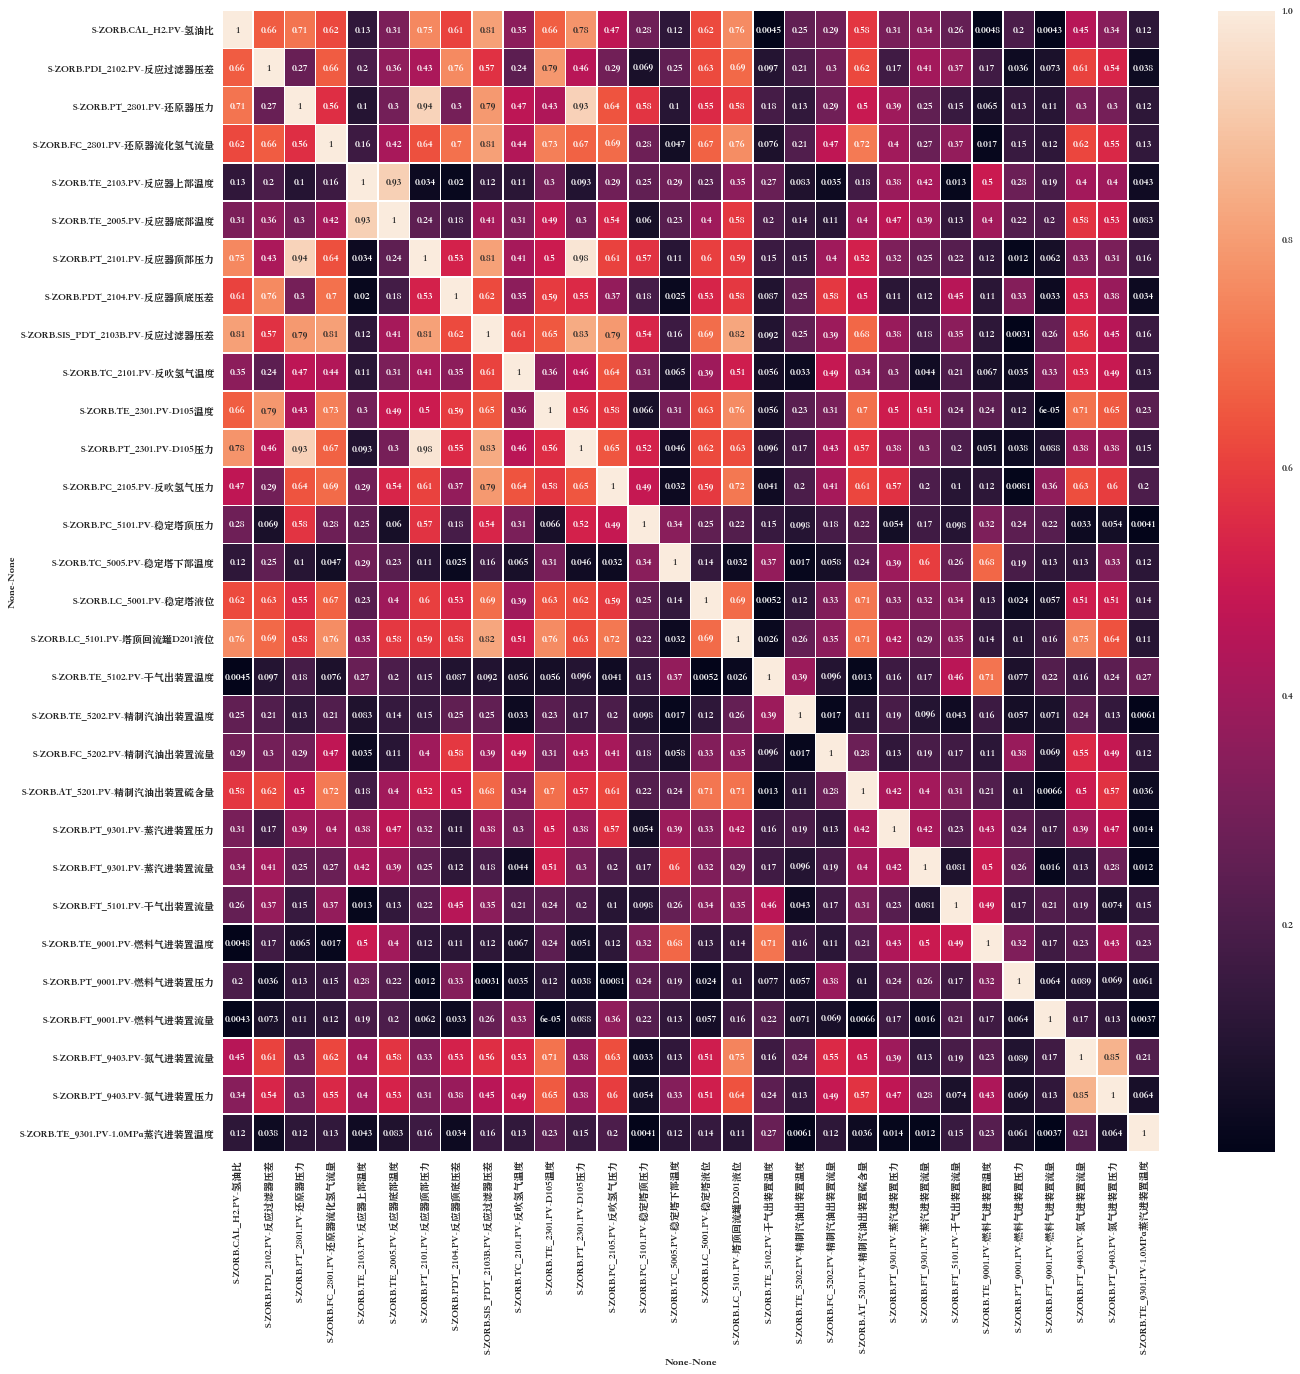

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 317 columns to remove.


In [6]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.TE_2103.PV,S-ZORB.TC_5005.PV,S-ZORB.TE_5102.PV,S-ZORB.TE_5202.PV,S-ZORB.PT_9001.PV,S-ZORB.FT_9001.PV,S-ZORB.TE_9301.PV,S-ZORB.LC_1201.PV,S-ZORB.PC_2601.PV,S-ZORB.TC_2607.PV,S-ZORB.LI_9102.DACA,S-ZORB.LC_3301.DACA,S-ZORB.LC_1203.DACA,S-ZORB.LT_1002.DACA,S-ZORB.FT_3501.DACA,S-ZORB.PC_3001.DACA,cluster
,氢油比,反应器上部温度,稳定塔下部温度,干气出装置温度,精制汽油出装置温度,燃料气进装置压力,燃料气进装置流量,1.0MPa蒸汽进装置温度,D104液面,再生器压力,再生器温度,D-204液位,D123冷凝水罐液位,D-121水液位,D-101脱水包液位,循环氢至闭锁料斗料腿流量,D-113压力,
305,0.275087,420.961348,129.351743,33.520163,36.548863,0.383871,439.088540,200.838835,49.991111,0.110208,488.732063,45.635215,51.424337,45.000710,-4.971108,-0.179180,0.050032,2
304,0.256952,422.196638,128.944752,31.103516,34.600812,0.380072,458.888505,201.778408,50.012023,0.110670,492.955478,49.315489,49.912188,44.975760,-4.967947,-0.018946,0.050016,2
299,0.258423,422.271200,128.704058,30.655869,32.879296,0.385952,444.876875,202.504448,50.011382,0.109804,497.615898,63.240493,50.419132,44.930244,-4.970005,-0.018842,0.049972,2
294,0.259134,424.813462,129.576562,32.073875,34.942990,0.401698,466.505145,194.873130,49.995656,0.110163,501.805650,44.337311,49.760661,40.032924,-4.967697,-0.017890,0.050014,2
293,0.257295,421.150175,130.364140,32.962725,34.979868,0.384814,457.310368,201.691710,50.018730,0.109950,507.405970,72.211829,50.155343,39.964054,-4.967920,-0.019202,0.050004,2


In [7]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(93, 7)
(93, 3)
(93, 18)


In [8]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [9]:
# Bootstrap Sampling
def bootstrap(data, size):
    return [random.choice(data) for _ in range(size)]

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
relate_features = set()
max_iter = 60
num_iter = 0
features_pool = list(set(manule_features.keys().to_numpy()))

while len(relate_features) <= int(len(features_pool)/3) and num_iter <= max_iter:
    choice_features = bootstrap(features_pool, int(manule_features.shape[1]/2))
    re_dimension = int(len(list(set(choice_features)))/3)
    tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
    X_tsne = tsne.fit_transform(manule_features[list(set(choice_features))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {len(list(set(choice_features)))}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 1 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 2 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 3 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 4 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 5 原始样本数据维度 9. t-SNE降维后的数据维度 3
num_iter => 6 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 7 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 8 原始样本数据维度 6. t-SNE降维后的数据维度 2
num_iter => 9 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 10 原始样本数据维度 9. t-SNE降维后的数据维度 3
num_iter => 11 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 12 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 13 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 14 原始样本数据维度 7. t-SNE降维后的数据维度 2
{('S-ZORB.CAL_H2.PV', '氢油比'), ('S-ZORB.FT_9001.PV', '燃料气进装置流量'), ('S-ZORB.TE_9301.PV', '1.0MPa蒸汽进装置温度'), ('S-ZORB.LT_1002.DACA', 'D-101脱水包液位'), ('S-ZORB.TC_2607.PV', '再生器温度'), ('S-ZORB.TC_5005.PV', '稳定塔下部温度'), ('S-ZORB.LC_3301.DACA', 'D123冷凝水罐液位')}


In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.CAL_H2.PV,S-ZORB.FT_9001.PV,S-ZORB.TE_9301.PV,S-ZORB.LT_1002.DACA,S-ZORB.TC_2607.PV,S-ZORB.TC_5005.PV,S-ZORB.LC_3301.DACA,原料性质,时间
,氢油比,燃料气进装置流量,1.0MPa蒸汽进装置温度,D-101脱水包液位,再生器温度,稳定塔下部温度,D123冷凝水罐液位,辛烷值RON,Unnamed: 1_level_1
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,9.300000e+01
mean,0.270226,464.955494,200.356313,-4.968501,499.783657,126.939316,49.949494,0.967430,1.539655e+18
std,0.023685,27.080702,12.282741,0.001944,6.840392,3.144027,0.686653,0.513329,2.945039e+16
min,0.227725,411.576765,178.126682,-4.972058,481.189695,117.567867,47.173305,-0.144010,1.496218e+18
25%,0.249530,446.224698,191.935982,-4.970134,495.470317,124.449520,49.765811,0.650225,1.514362e+18
50%,0.270549,465.777508,200.838835,-4.968547,500.145345,127.868155,50.011248,0.877149,1.533542e+18
75%,0.296127,478.395915,207.729875,-4.966918,504.984882,129.383410,50.187919,1.330997,1.559894e+18
max,0.306238,560.031320,249.179738,-4.964648,512.527607,132.295670,52.217606,2.125231,1.590480e+18


In [12]:
weight_2nd = manule_features.shape[0]/samples_features.shape[0]
model_features_2nd = model_features
produc_features_2nd = produc_features
%store model_features_2nd
%store produc_features_2nd
%store weight_2nd

Stored 'model_features_2nd' (DataFrame)
Stored 'produc_features_2nd' (DataFrame)
Stored 'weight_2nd' (float)
